In [8]:
import json
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')
sns.set_context('paper')

rdirs = [
    '../results/results_23-01-30/'
        ]
figdir='../overleaf/figs/'
def save(fig, name):
#     fig.tight_layout()
    for t in ['.pdf','.jpg']:
        plt.savefig(figdir+name+t, 
                    dpi=300,
                    bbox_inches='tight'
                   )

In [2]:
frames = []
# cols = [
#     'algorithm',
#     'random_state',
#     'time_time',
#        ]
globs = []
for rdir in rdirs:
    globs.extend(glob(rdir+'/*.stats'))
for f in globs:
#     print(f)
    df = pd.read_csv(f).drop(columns='Unnamed: 0')
    fj = f.replace('.stats','.json')
    with open(fj,'r') as file:
        try:
            dj = json.load(file)
        except Exception as e:
            print('!!!Failed to load',fj)
            print(e)
            continue
    for k,v in dj.items():
        if k == 'groups':
            v =','.join(v)
        if not isinstance(v, list):
            df[k] = v
    frames.append(df)    
df_results = pd.concat(frames)
# print(len(frames),'records')
# print(frames[0].keys())

df_results['ML'] = df_results['algorithm'].apply(lambda x: x.split('_pmc')[0].split('_mc')[0].upper())
df_results['postprocessing'] = df_results['algorithm'].apply(lambda x: 'MC-CV' if '_mc_cv' in x else x)
df_results['postprocessing'] = df_results['postprocessing'].apply(lambda x: 'MC' if '_mc' in x else x)
df_results['postprocessing'] = df_results['postprocessing'].apply(lambda x: 'PMC-CV' if '_pmc_cv' in x else x)
df_results['postprocessing'] = df_results['postprocessing'].apply(lambda x: 'PMC-log' if '_pmc_log' in x else x)
df_results['postprocessing'] = df_results['postprocessing'].apply(lambda x: 'PMC' if '_pmc' in x else x)
df_results['postprocessing'] = df_results['postprocessing'].apply(
    lambda x: 'Base Model' if 'MC' not in x else x
)
df_results.loc[df_results['ML']=='lr_cv','ML'] = 'LR'

df_results['Wall Clock Time (s)'] = df_results['time_time']

df_results['groups'] = df_results['groups'].apply(lambda x: ','.join(x) if isinstance(x,list) else x)
# # df_results = df_results.loc[df_results.n_bins==10]
# # df_results = df_results.loc[df_results.groups!='ethnicity,gender,anchor_year_group']
# # df_results = df_results.loc[df_results.gamma==0.05]
# # df_results = df_results.loc[df_results.rho==0.001]
# df_results.groupby('algorithm')['random_state'].count()

In [20]:
for c in ['ML','postprocessing','alpha','gamma','rho','groups']:
    print(c)
    print(df_results[c].value_counts())

ML
RF    111542
LR     89020
Name: ML, dtype: int64
postprocessing
PMC        83710
PMC-log    75000
MC         41852
Name: postprocessing, dtype: int64
alpha
0.001    122864
0.010     54044
0.100     14774
0.200      8880
Name: alpha, dtype: int64
gamma
0.01    149475
0.05     51087
Name: gamma, dtype: int64
rho
0.01    67936
0.05    51744
0.10    45916
0.50    34966
Name: rho, dtype: int64
groups
ethnicity,gender              115692
ethnicity,gender,insurance     84870
Name: groups, dtype: int64


In [4]:
df_plt = df_results.melt(
    id_vars = ['iteration','ML','postprocessing','alpha','gamma','rho','groups'],
    value_vars = ['MC','PMC'] #,'MSE','# updates','# categories']
)

In [5]:
df_plt

,iteration,ML,postprocessing,alpha,gamma,rho,groups,variable,value
0,0,LR,PMC-log,0.001,0.05,0.1,"ethnicity,gender,insurance",MC,0.097616
1,1,LR,PMC-log,0.001,0.05,0.1,"ethnicity,gender,insurance",MC,0.082095
2,2,LR,PMC-log,0.001,0.05,0.1,"ethnicity,gender,insurance",MC,0.057863
3,3,LR,PMC-log,0.001,0.05,0.1,"ethnicity,gender,insurance",MC,0.077417
4,4,LR,PMC-log,0.001,0.05,0.1,"ethnicity,gender,insurance",MC,0.029477
...,...,...,...,...,...,...,...,...,...
401119,6,RF,PMC,0.200,0.05,0.1,"ethnicity,gender,insurance",PMC,0.320909
401120,7,RF,PMC,0.200,0.05,0.1,"ethnicity,gender,insurance",PMC,0.240682
401121,8,RF,PMC,0.200,0.05,0.1,"ethnicity,gender,insurance",PMC,0.197042
401122,0,LR,MC,0.100,0.05,0.1,"ethnicity,gender",PMC,0.599691


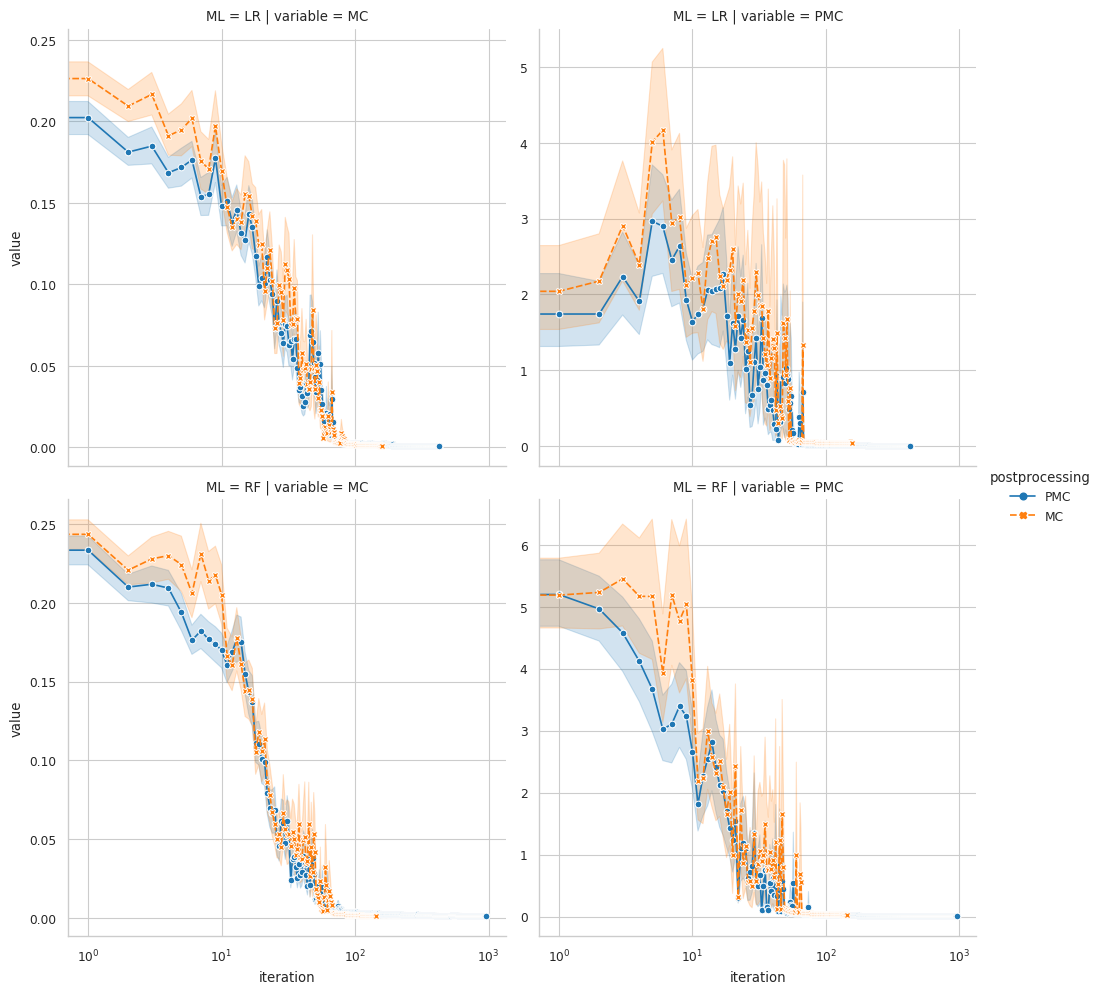

In [23]:
g = sns.relplot(
    kind='line',
#     estimator='median',
#     estimator=None,
#     err_style='bars',
    markers=True,
    data = df_plt.loc[
#         (df_plt.alpha==0.001) 
#         & (df_plt.gamma==0.05) 
        (df_plt.rho<.5)
        & (df_plt.postprocessing.isin(['MC','PMC']))
    ],
    x = 'iteration',
    y = 'value',
    hue='postprocessing',
    style='postprocessing',
    row='ML',
    col='variable',
    facet_kws = dict(sharey=False)
)
g.set(xscale='log')